In [1]:
%matplotlib inline
import matplotlib.pyplot as plt      
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam
from datasets import WaveNetDataset

## Sine Wave to test with Wavenet

In [2]:
PATH = '/home/austin/data/tacotron/LJSpeech-1.0'

In [3]:
dataset = WaveNetDataset(PATH)

In [4]:
s, a = dataset[1]

In [5]:
s.shape

(153, 80)

In [6]:
a.shape

(41885,)

In [7]:
np.prod([4, 4, 4, 4])

256

In [8]:
len(a) / s.shape[0]

273.75816993464053

In [9]:
sine_wave = np.sin(np.arange(0, 10, 0.1))

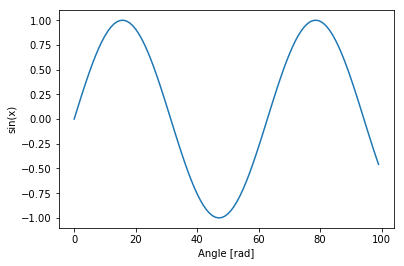

In [10]:
plt.plot(sine_wave)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight');


## Encoding from the first wavenet paper, tacotron2 uses MoL encoding instead

In [11]:
def mu_law_encode(signal, mu=256):
    """
    Quantizes a signal to mu number discrete values.
    """
    mu = mu-1
    fx = np.sign(signal) * (np.log(1 + mu*np.abs(signal))/
                           np.log(1 + mu))
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)


def decode_mu_law(quantized_signal, mu=256):
    mu = mu-1
    fx = (quantized_signal-0.5)/mu*2-1
    x = (np.sign(fx)/
         mu*((1+mu)**np.abs(fx)-1))
    return x


def one_hot_encode(indices, num_categories=256):
    batch_size, sequence_length = indices.size()
    one_hot = torch.zeros(batch_size, num_categories, sequence_length)
    one_hot.scatter_(1, indices.unsqueeze(dim=1), 1.0)
    return Variable(one_hot)

In [12]:
mu_sine = mu_law_encode(sine_wave)

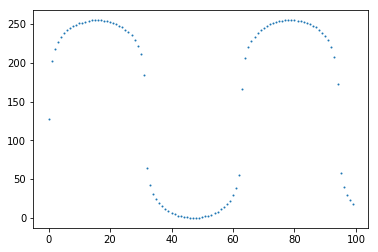

In [13]:
plt.plot(mu_sine,'.', ms=2);

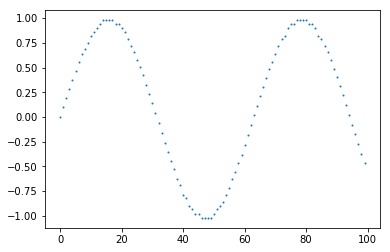

In [14]:
plt.plot(decode_mu_law(mu_sine), '.', ms=2);

In [15]:
class OneHot(nn.Module):
    """
    One hot encodes a categorical sequence
    functions similar to an embedding layer
    """
    
    def __init__(self, num_categories=256):
        super(OneHot, self).__init__()
        self.num_categories = num_categories
        
    def forward(self, indices):
        indices = indices.data
        batch_size, sequence_length = indices.size()
        one_hot = indices.new(batch_size, self.num_categories, sequence_length).zero_()
        one_hot.scatter_(1, indices.unsqueeze(dim=1), 1)
        return Variable(one_hot.float())   

## Causal Convolution

In [16]:
class CausalConv1d(nn.Module):
    """
    pads the left side of input sequence just enough so that the convolutional kernel
    does not look into the future.
    
    Input and output sizes will be the same.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[..., :-self.conv1.padding[0]]  # remove trailing padding
        return x

In [17]:
class ResidualLayer(nn.Module):
    """
    A wavenet causal gated residual layer.
    """
    
    def __init__(self, residual_channels, skip_channels, dilation, conditioning_channels=None):
        super(ResidualLayer, self).__init__()
        self.conv_filter = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=3, dilation=dilation)
        self.conv_gate = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=3, dilation=dilation)        
        self.resconv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skipconv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)
        
        if conditioning_channels:
            self.conditioning_conv1x1 = nn.Conv1d(conditioning_channels, residual_channels * 2, kernel_size=1)

            
        
    def forward(self, x, local_conditioning=None):
        conv_filter = self.conv_filter(x)
        conv_gate = self.conv_gate(x)
        
        if local_conditioning is not None:
            local_conditioning = self.conditioning_conv1x1(local_conditioning)
            local_conditioning_filter, local_conditioning_gate = local_conditioning.chunk(chunks=2, dim=1)
            conv_filter += local_conditioning_filter
            conv_gate += local_conditioning_gate
            
        fx = F.tanh(conv_filter) * F.sigmoid(conv_gate)
        fx = self.resconv(fx) # restore feature dims with 
        skip = self.skipconv(fx)  # conv1x1 goes to skip connections
        residual = fx + x  # residual output goes to next layer
        return skip, residual
        

In [18]:
class DilatedStack(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation_depth, conditioning_channels=None):
        """
        Block of dilated residual layers
        Dilation increases exponentially, final dilation will be 2**num_layers.
        a 10 layer block has a receptive field of 1024 (kernel_size * dilation).
        """
        super(DilatedStack, self).__init__()
        residual_stack = [ResidualLayer(residual_channels, skip_channels, 2**layer, conditioning_channels)
                         for layer in range(dilation_depth)]
        self.residual_stack = nn.ModuleList(residual_stack)
        
    def forward(self, x, local_conditioning=None):
        skips = []
        for layer in self.residual_stack:
            skip, x = layer(x, local_conditioning)
            skips.append(skip.unsqueeze(0))
        return torch.cat(skips, dim=0), x  # layers, batch, features, seq
    

In [19]:
class UpsamplingNetwork(nn.Module):
    """Upsamples local conditioning variables to the same length as input.

    """
    def __init__(self, conditioning_channels, scales):
        super(UpsamplingNetwork, self).__init__()
        upsample_layers = [nn.ConvTranspose1d(conditioning_channels, conditioning_channels,
                                        kernel_size=3, stride=scale, padding=1, output_padding=1)
                           for scale in scales]
        self.upsample_layers = nn.ModuleList(upsample_layers)

    def forward(self, x):
        for upsample in self.upsample_layers:
            x = upsample(x)
        return x

In [20]:
class WaveNet(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation_cycles, dilation_depth, conditioning_channels=None, upsampling_scales=None):
        super(WaveNet, self).__init__()
        self.conditioning_channels = conditioning_channels
        self.upsampling_scales = upsampling_scales
        self.one_hot_encode = OneHot(num_categories=256)
        self.input_conv = CausalConv1d(in_channels=256, out_channels=residual_channels, kernel_size=3)        
        self.dilated_stacks = nn.ModuleList(
            [DilatedStack(residual_channels, skip_channels, dilation_depth, conditioning_channels)
             for cycle in range(dilation_cycles)]
        )
        self.convout_1 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=1)
        self.convout_2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=1)
        
        if conditioning_channels and upsampling_scales:
            self.local_conditioning_upsample = UpsamplingNetwork(conditioning_channels, upsampling_scales)

        
    def forward(self, x, local_conditioning=None):
        x = self.one_hot_encode(x) # [batch, num_mu, seq_len]
        x = self.input_conv(x) # [1, 256, 100] expects one_hot encoded inputs
        
        if local_conditioning is not None:
            if not self.conditioning_channels and not self.upsampling_scales:
                raise ValueError('set conditioning_channels, and upsampling_scales to use local_conditioning.')    
            local_conditioning = self.local_conditioning_upsample(local_conditioning)
            
        skip_connections = []
        for cycle in self.dilated_stacks:
            skips, x = cycle(x, local_conditioning) # [5, 1, 16, 100] and [1, 32, 100]
            skip_connections.append(skips)
        skip_connections = torch.cat(skip_connections, dim=0) # [10, 1, 16, 100]
        
        # gather all output skip connections to generate output, discard last residual output
        out = skip_connections.sum(dim=0) # [1, 16, 100]
        out = F.relu(out)
        out = self.convout_1(out) # [1, 256, 100]
        out = F.relu(out)
        return self.convout_2(out)
    
    def generate(self, start, local_conditioning, maxlen=100):
        outputs = [start]
        for i in range(maxlen):
            probs = self.forward(torch.cat(outputs, dim=1), local_conditioning) # P(all_next|all previous)
            _, output = probs[..., -1:].max(dim=1) # get prob for the last word and take max idx
            outputs.append(output)
        return torch.cat(outputs, dim=1)[..., start.size(dim=1):]
     

In [21]:
def sine_generator(seq_size= 30001, mu=256):
    framerate = 44100
    t = np.linspace(0, 5, framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0, data.shape[0] - seq_size)
        sine = data[start:start+seq_size]
        mu_sine = mu_law_encode(sine, mu)
        mu_sine = torch.from_numpy(mu_sine).unsqueeze(0)
        yield Variable(mu_sine[..., :seq_size]).cuda()

In [22]:
wavenet = WaveNet(residual_channels=512, skip_channels=256, dilation_cycles=2, dilation_depth=10, conditioning_channels=1, upsampling_scales=[2, 2])

In [23]:
optimizer = Adam(wavenet.parameters(), lr=1e-2)

In [24]:
g = sine_generator(seq_size=3001)


In [25]:
batch = next(g)
conditional = batch[:, :750].view(1, 1, -1).float()

In [30]:
wavenet(batch[:, :-1].cpu(), conditional.cpu())

Variable containing:
( 0  ,.,.) = 
  6.6366e-02  8.9705e-03 -1.3580e-01  ...   1.6499e-03 -7.1411e-02  1.0277e-01
 -8.4379e-02 -2.4416e-01 -3.2983e-01  ...  -1.7572e-01 -2.3323e-01 -1.2676e-01
  1.5932e-02  1.1617e-02  4.2358e-02  ...  -1.6942e-02  4.9782e-02 -6.1901e-02
                 ...                   ⋱                   ...                
  3.2938e-02  4.9972e-03 -3.2651e-02  ...   7.1967e-02  3.5655e-02  5.6869e-02
 -4.3091e-02  1.0843e-02 -1.1654e-02  ...  -3.9647e-02 -1.8494e-02 -3.4647e-02
  1.8127e-01  9.0762e-02  9.2551e-03  ...   9.4830e-02  4.6373e-02  2.3488e-01
[torch.FloatTensor of size 1x256x3000]

In [31]:
wavenet.cuda(device=0)

WaveNet(
  (one_hot_encode): OneHot(
  )
  (input_conv): CausalConv1d(
    (conv1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(2,))
  )
  (dilated_stacks): ModuleList(
    (0): DilatedStack(
      (residual_stack): ModuleList(
        (0): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,))
          )
          (resconv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
          (skipconv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
          (conditioning_conv1x1): Conv1d(1, 1024, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
          )
          (conv_gate): CausalConv1d(
            (conv1): 

In [33]:
for i in range(100): 
    batch = next(g)
    x = batch[..., :-1]
    y = batch[..., 1:]
    out = wavenet(x.cuda(device=0), batch[:, :750].view(1, 1, -1).float().cuda(device=0))
    loss = F.cross_entropy(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(i, loss.data[0])

0 5.54139518737793
50 5.519702434539795


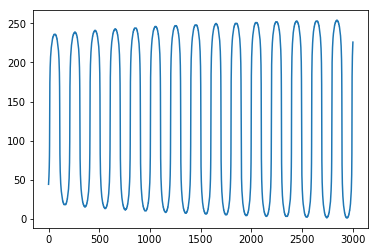

In [34]:
plt.plot(next(g).data[0])

## Exponential Time Generation zzz...

In [ ]:
%time gen_wave = wavenet.generate(x[:,-1:],  batch[:, :750].view(1, 1, -1).float().cuda(device=0), maxlen=100)
plt.plot(gen_wave.data[0]);